This is the Group 9 Project Report ipynb File!

The following cell loads the packages that we will be using for this project

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

This cell will import our data from a link. The link is a public GitHub created by Ryan as the link directly from the source was a .zip file. The GitHub allows us to get around this problem

In [2]:
url <- "https://raw.githubusercontent.com/EPICxFLIPPER/data/main/OnlineNewsPopularity.csv"
popularity <- read_csv(url) 

head(popularity)

Rows: 39644 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): url
dbl (60): timedelta, n_tokens_title, n_tokens_content, n_unique_tokens, n_no...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


The next cell wrangles our data. This data was already quite tidy, only a few null values had to be removed. We also selected our predictor, word count, and the column being predicted, shares. Through our exploritory analysis, there were quite a few outlier points, both that had high shares, and high word counts. We have also removed a significant number of these points below.

In [13]:
set.seed(9)
#Wrangling
popularity_tidy <- popularity |> 
#removing columns that are specifically not litsted as predictors as well as columns that self reference articles.
select(shares,n_tokens_content) |>
filter(shares < 1000)|>
arrange(desc(shares)) |>
slice(-1:-1500) |>
arrange(desc(n_tokens_content)) |>
slice(-1:-1500) |>
drop_na(n_tokens_content, shares) |>
filter(shares != 0, n_tokens_content != 0)
#Removed Outliers


glimpse(popularity_tidy)

Rows: 7,981
Columns: 2
$ shares           <dbl> 811, 802, 690, 528, 889, 740, 721, 649, 907, 804, 709…
$ n_tokens_content <dbl> 867, 867, 867, 867, 866, 866, 866, 866, 865, 865, 865…


In [14]:
set.seed(9)
popularity_sample <- sample_n(popularity_tidy, 3000)

In [15]:
set.seed(9)
#Splitting the data into training and testing data
#Strata = the day the article was published
popularity_split<- initial_split(popularity_sample, prop = .70, strata = shares)
popularity_train<- training(popularity_split)
popularity_test <- testing(popularity_split)


In [16]:
set.seed(9)
initial_table <- popularity_train |>
map_df(mean, na.rm =TRUE)
initial_table

summary <- summary(popularity_train)
summary

shares,n_tokens_content
<dbl>,<dbl>
715.9566,395.5553


     shares      n_tokens_content
 Min.   : 49.0   Min.   : 39.0   
 1st Qu.:613.0   1st Qu.:239.0   
 Median :744.5   Median :356.0   
 Mean   :716.0   Mean   :395.6   
 3rd Qu.:844.0   3rd Qu.:534.0   
 Max.   :939.0   Max.   :867.0   

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


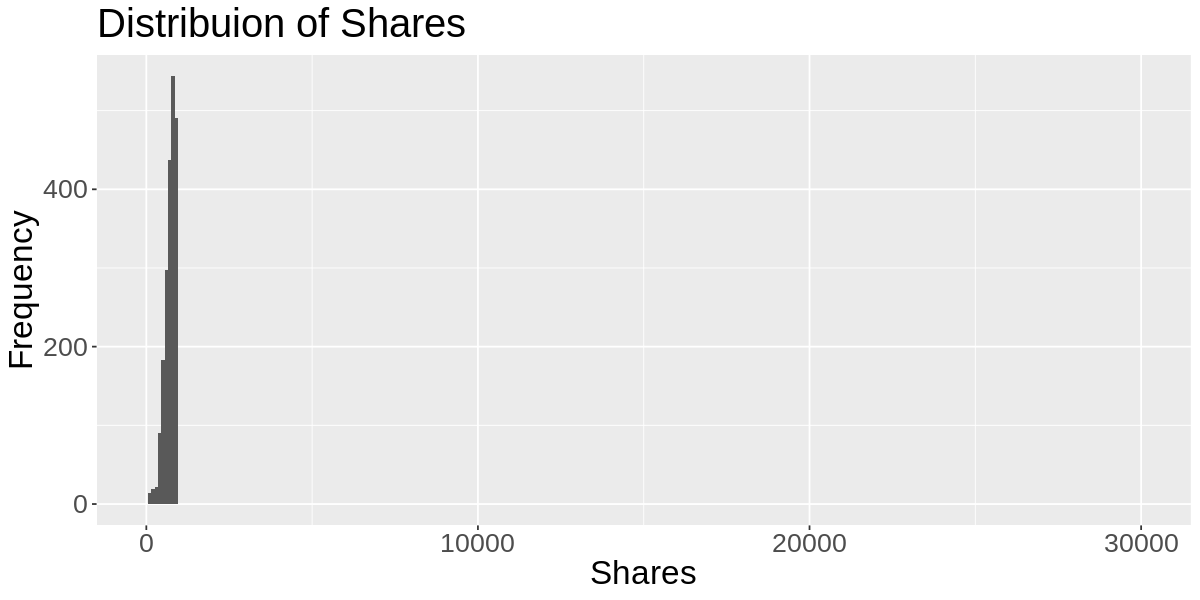

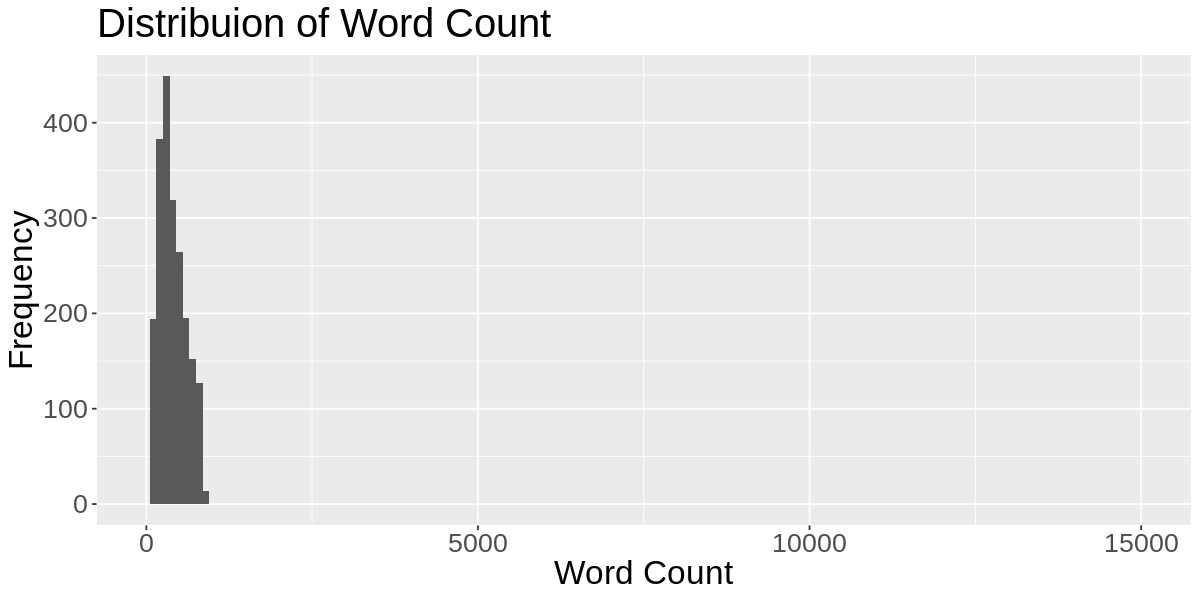

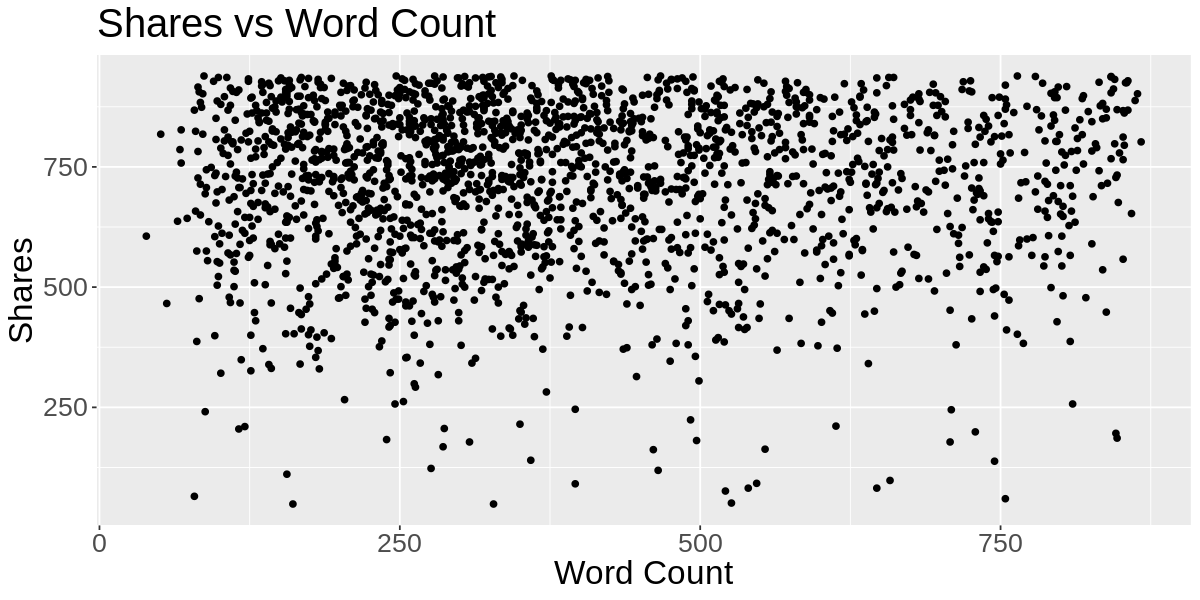

In [17]:
set.seed(9)
#Below are the distributions of the 3 most varable categoreis in our data set. Though some of the categories are less variable, we belive 
#they will still be good predictors of shares.

options(repr.plot.width = 10, repr.plot.height =5)

shares_plot <- popularity_train |> 
ggplot(aes(x = shares)) + geom_histogram(binwidth = 100)+xlim(0,30000) +labs(x = "Shares" , y = "Frequency") +
ggtitle("Distribuion of Shares") + theme(text = element_text(size = 20))

words_plot <- popularity_train |> 
ggplot(aes(x = n_tokens_content)) + geom_histogram(binwidth = 100)+xlim(0,15000) +labs(x = "Word Count" , y = "Frequency") +
ggtitle("Distribuion of Word Count") + theme(text = element_text(size = 20))


shares_vs_word_count_plot <- popularity_train |>
ggplot(aes(x = n_tokens_content , y = shares)) + geom_point() + xlab("Word Count") + ylab("Shares") + ggtitle("Shares vs Word Count") +
theme(text = element_text(size = 20))

shares_plot
words_plot
shares_vs_word_count_plot


In [18]:
#I will be loacting the best neighbors to use
set.seed(9)
popularity_spec <- nearest_neighbor(weight_func = "rectangular" , neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("regression")

popularity_recipe <- recipe(shares~n_tokens_content, data = popularity_train) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())

gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
popularity_vfold <- vfold_cv(data = popularity_train, v = 5, strata = shares)

popularity_fit <- workflow() |>
add_recipe(popularity_recipe) |>
add_model(popularity_spec) |>
tune_grid(resamples = popularity_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse") |>
arrange(mean) |>
select(neighbors) |>
slice(1) |>
pull()



popularity_fit
                   


[1] 24

In [1]:
set.seed(9)
popularity_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
set_engine("kknn") |> 
set_mode("regression")

popularity_fit_2 <- workflow() |> 
add_recipe(popularity_recipe) |>
add_model(popularity_spec) |>
fit(data = popularity_train)

popularity_predictions <- predict(popularity_fit_2, popularity_test) |> 
bind_cols(popularity_test)

head(popularity_predictions)

ERROR: Error in set_mode(set_engine(nearest_neighbor(weight_func = "rectangular", : could not find function "set_mode"


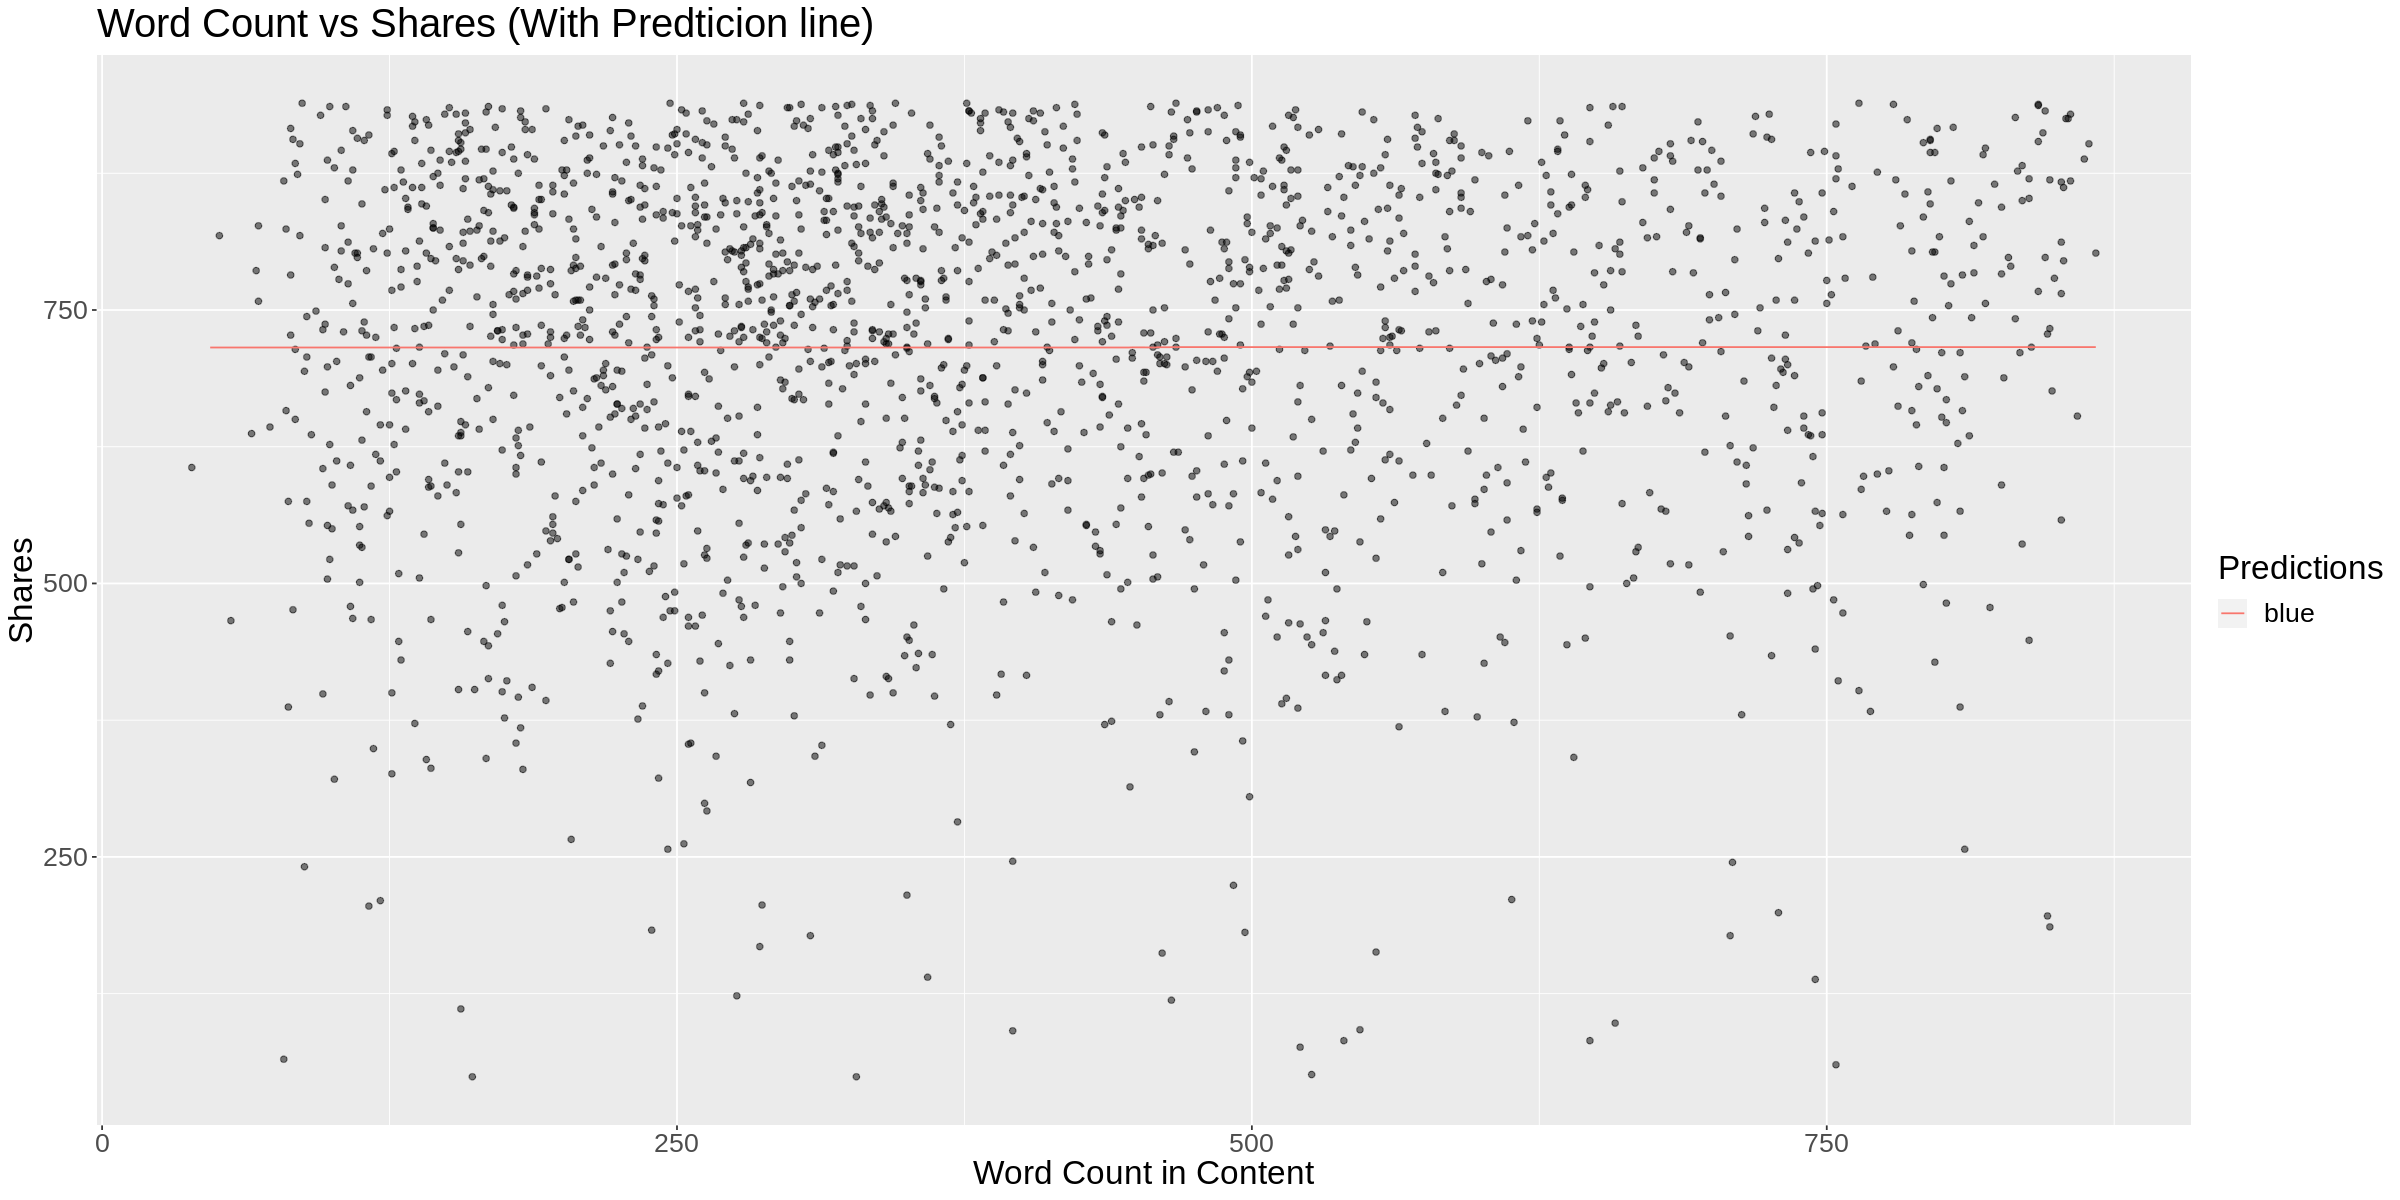

In [20]:
set.seed(9)
options(repr.plot.width = 20 , repr.plot.height =10)
predictions_plot <- popularity_train |> 
ggplot(aes(x = n_tokens_content , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = n_tokens_content , y = .pred, color = "blue")) +
labs(x = "Word Count in Content" , y = "Shares", color = "Predictions")+
ggtitle("Word Count vs Shares (With Predticion line)") + theme(text = element_text(size = 20))
predictions_plot